In [1]:
import pandas as pd
from config import config
import numpy as np
import matplotlib.pyplot as plt
from pipeline import visualisation_pipeline, best_sm_rf_pipeline
from pipeline import rf_pipeline, lr_pipeline, sm_rf_pipeline, sm_lr_pipeline,rus_rf_pipeline, rus_lr_pipeline
from helpers import get_meta_columns, plot_categoricial, plot_discrete, plot_continuous, plot_temp, get_feature_importance,plot_occupation
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, plot_confusion_matrix
sns.set_style("whitegrid")


In [2]:
def get_data(mode='train', missing_val=' ?'):
    """gets the training or testing data
    encodes the target variable to binary
    returns: DataFrame
    """
    # reads in the data
    if mode == 'train':
        df = pd.read_csv(config.TRAIN_DIR, names=get_meta_columns(), na_values=missing_val)
    else:
        df = pd.read_csv(config.TEST_DIR, names=get_meta_columns(), na_values=missing_val)
        
    # encodes the target variable as binary
    df[config.TARGET] = df[config.TARGET].map(config.TARGET_ENCODING)
    return df

data = get_data()
 
# splits the data in to a training and validation set
X_train, X_test, y_train, y_test = train_test_split(
         data[config.FEATURES], data[config.TARGET], test_size=0.2, random_state=0
         )  


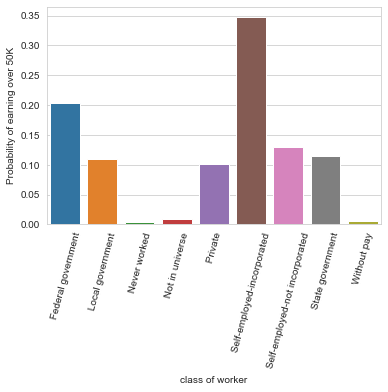

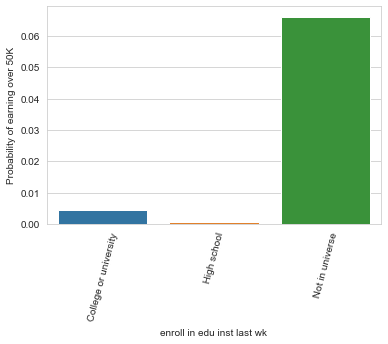

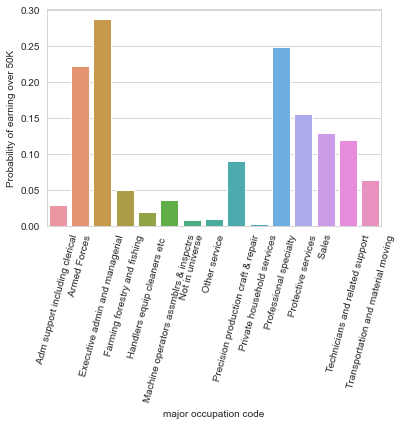

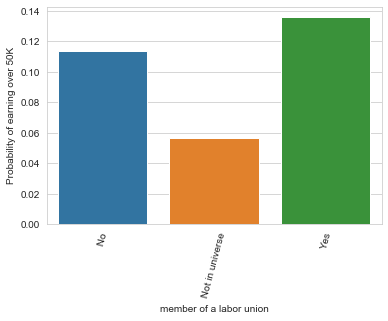

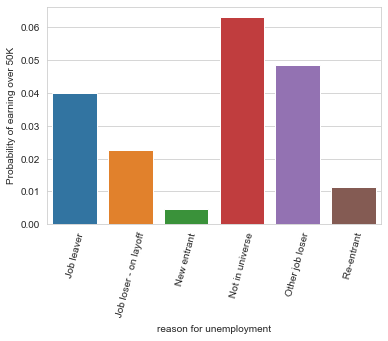

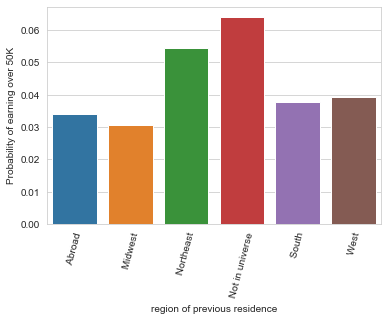

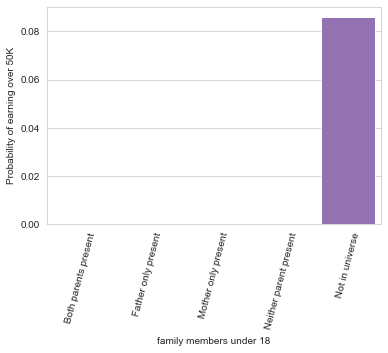

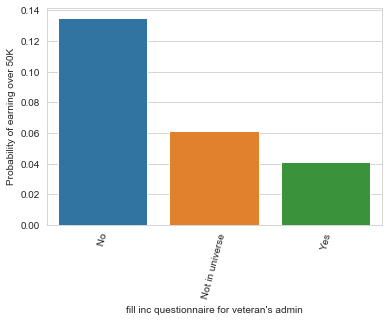

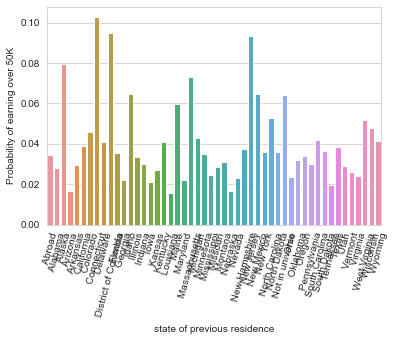

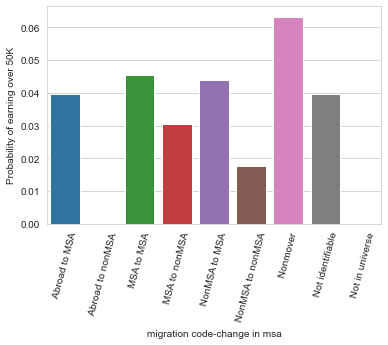

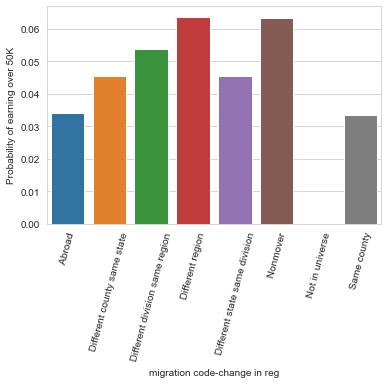

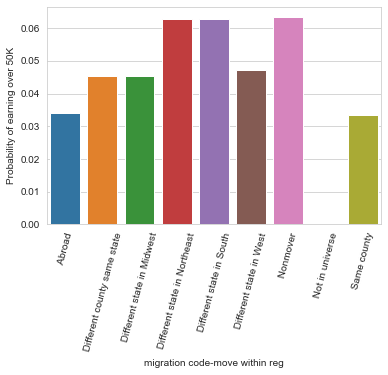

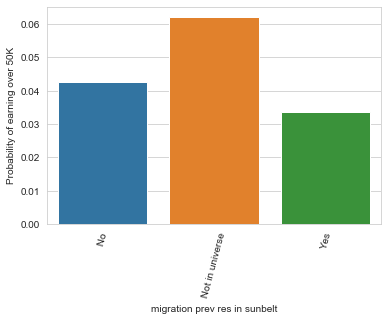

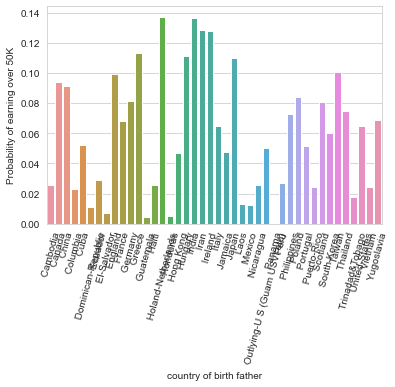

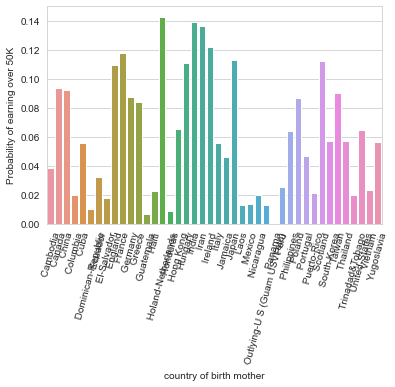

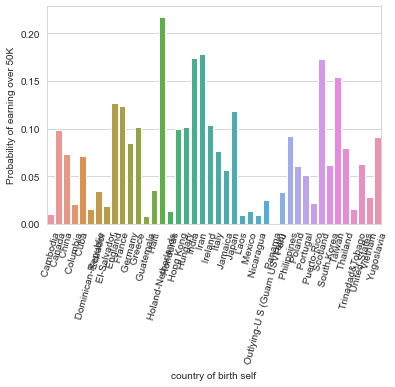

In [3]:
temp_df = get_data(mode='train', missing_val=' Not in universe')
for var in config.NOT_IN_UNIVERSE_MISSING_VARS: 
    plot_temp(data, var)
temp_df = get_data(mode='train', missing_val=' ?')
for var in config.MISSING_VARS_QMARK:
    plot_temp(data, var)
    

In [ ]:
for var in config.CATEGORICAL_VALS
    if len(data[var].unique())>15:
        print(var, 'has ' + str(len(data[var].unique()))+ " categories")
        # HIGH_CARDINALITY_VARS.append(var)


In [5]:
def process_data_visualisation(X_train, y_train):
    """Transforms data for visualisations
    uses a visualisation pipeline to preprocess the data
    visualisation pipeline: 
        Encodes NA values,
        Removes duplicate columns
        Performs Feature Engineering on education and weeks worked
        Ordered Ordinal encoding for Categorical variables
    returns: DataFrame
    """
    x_train_processed = visualisation_pipeline.fit_transform(X_train[config.FEATURES], y_train)
    return pd.DataFrame(pd.concat([x_train_processed, y_train], axis=1))

plotting_df = process_data_visualisation(X_train, y_train)


----Categorical Variables -----


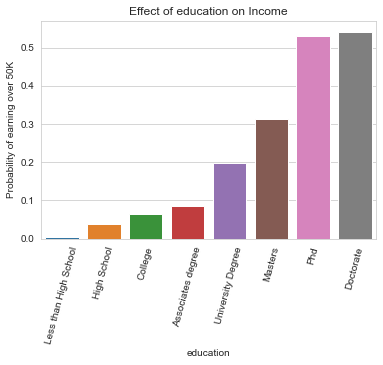

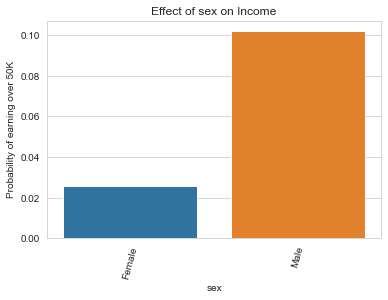

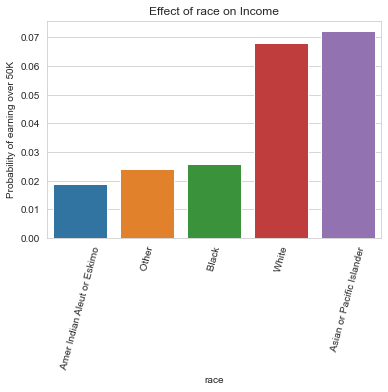

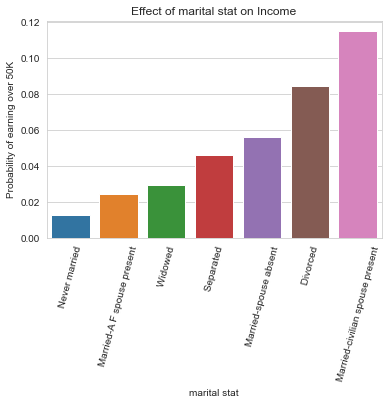

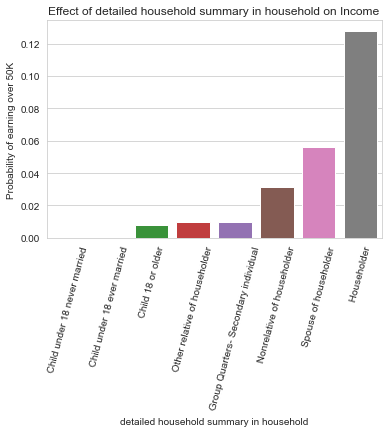

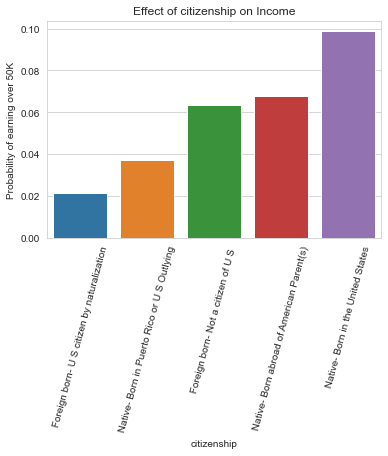

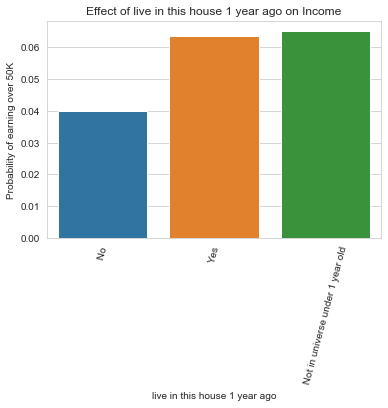

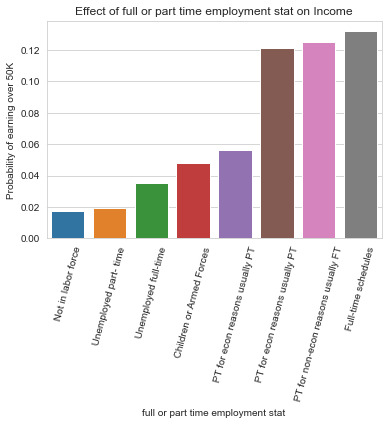

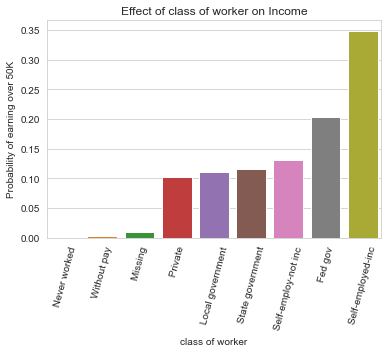

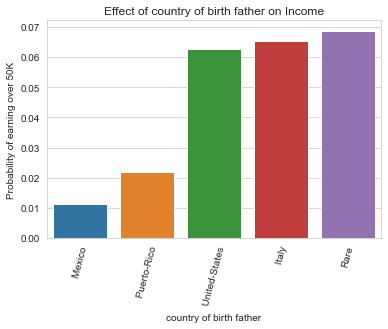

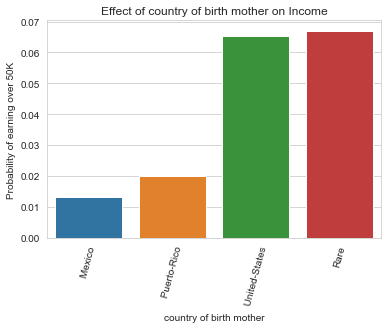

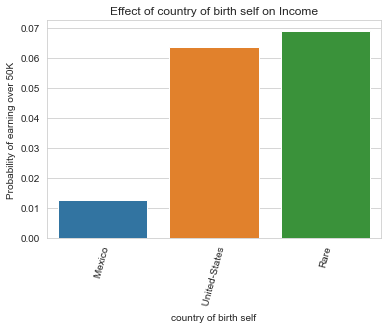

In [5]:
print('----Categorical Variables -----')
for var in config.VIS_CATEGORICAL_VALS:
    if var not in config.CATEGORICAL_VALS_NOT_PLOTTED:
        plot_categoricial(plotting_df, var)

----Discrete Variables -----


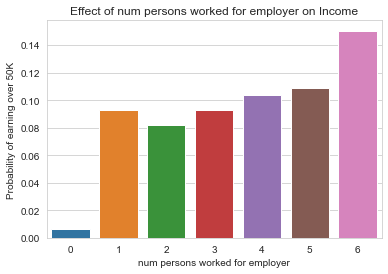

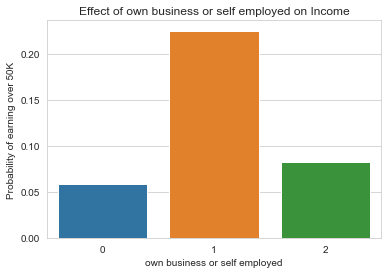

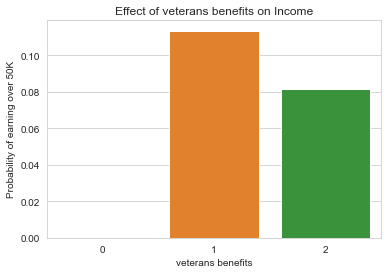

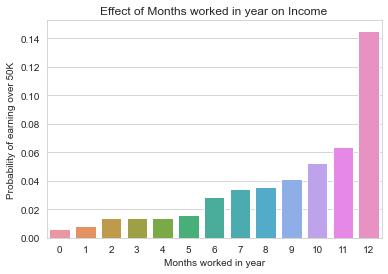

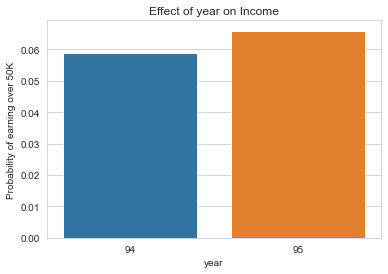

In [4]:
print('----Discrete Variables -----')
for var in config.DISCRETE_NUMERIC_VARS:
    if var not in config.DISCRETE_NOT_PLOTTED:
        plot_discrete(plotting_df, var)

----Continuous Variables -----


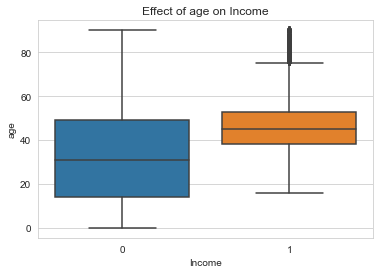

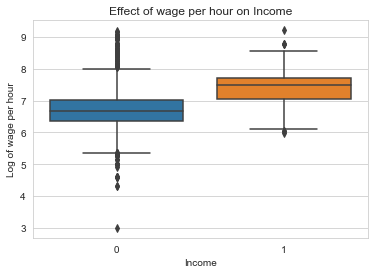

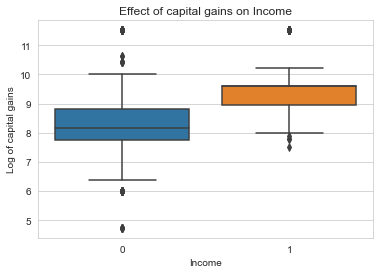

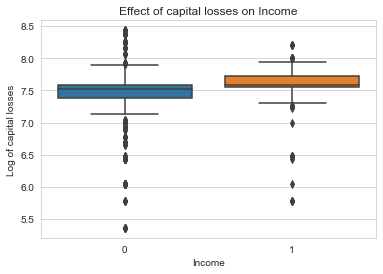

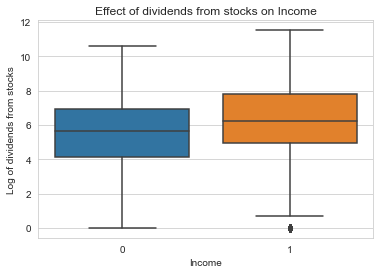

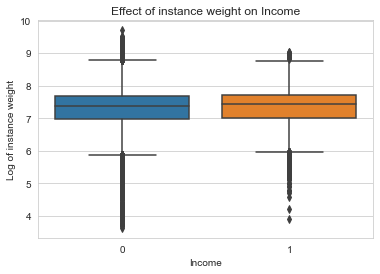

In [5]:
# skewed variables have been logged

print('----Continuous Variables -----')
for var in config.CONTINUOUS_NUMERIC_VARS:
    plot_continuous(plotting_df, var)

----OCCUPATION Variables -----


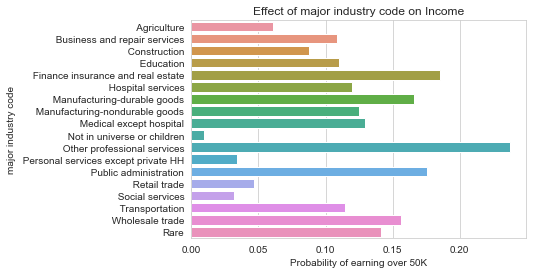

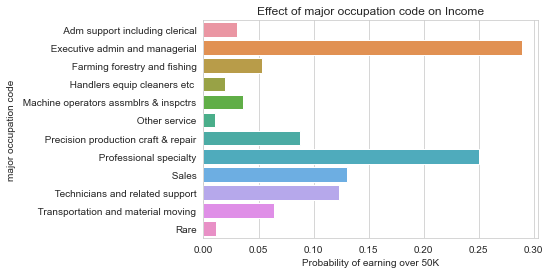

In [6]:
print('----OCCUPATION Variables -----')
for var in config.OCCUPATION:
    plot_occupation(plotting_df, var)

In [9]:
def train_models( X_train, X_test, y_train, y_test):
    """Trains the models using sklearn pipelines
    Preprocessing steps shared by all pipelines are:
        1. Encode Not in universe as np.NAN
        2. Fill NA's with "missing"
        3. Encode Categorical as ordinal
        4. Encode education using feature engineering
        5. log transform skewed numeric variables
        6. Normalises all variable using min max
        7. Drops correlated variables
    Variability in resampling methods:
        1. No method
        2. SMOTE (Synthetic 
    returns: Dict, DataFrame
    """	
    models = {
        'Random_Forest': rf_pipeline,
        'RUS_Random_Forest':rus_rf_pipeline,
        'Smote_Random_Forest': sm_rf_pipeline,
        'Logistic_Regression': lr_pipeline,
        'RUS_Logistic_Regression': rus_lr_pipeline,
        'Smote_Logistic_Regression': sm_lr_pipeline
        }
    results = {
		'Model': [],
		'Accuracy': [],
		'F1_Score': [],
		'Recall_Score': []
	}
    
    
    for key in models:
        models[key].fit(X_train, y_train)
        y_pred = models[key].predict(X_test)
        results['Model'].append(key)
        results['Accuracy'].append(accuracy_score(y_test, y_pred))
        results['F1_Score'].append(f1_score(y_test, y_pred))
        results['Recall_Score'].append(recall_score(y_test, y_pred))
    results = pd.DataFrame(results)
    print(results)
    return models, results

models, results = train_models(X_train, X_test, y_train, y_test)

                       Model  Accuracy  F1_Score  Recall_Score
0              Random_Forest  0.955194  0.542711      0.437887
1          RUS_Random_Forest  0.853377  0.426429      0.897648
2        Smote_Random_Forest  0.949179  0.564994      0.543541
3        Logistic_Regression  0.951535  0.476732      0.363599
4    RUS_Logistic_Regression  0.847187  0.412863      0.884853
5  Smote_Logistic_Regression  0.849292  0.414297      0.877837


In [3]:
rf_range = {
    'rf__n_estimators': [int(x) for x in np.linspace(10, 50, num = 6)],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_depth': [int(x) for x in np.linspace(10, 110, num = 6)]
                 }

rf_random_s = RandomizedSearchCV(estimator=sm_rf_pipeline , 
                             param_distributions=rf_range,
                             n_iter = 10, 
                             cv = 3, verbose=1, scoring = 'f1'
                             ) 
rf_detector = rf_random_s.fit(data[config.FEATURES], data[config.TARGET])
print(rf_detector.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Pipeline(steps=[('EncodeNotInUniverse',
                 EncodeNotInUniverse(variables=['age', 'class of worker',
                                                'detailed industry recode',
                                                'detailed occupation recode',
                                                'education', 'wage per hour',
                                                'enroll in edu inst last wk',
                                                'marital stat',
                                                'major industry code',
                                                'major occupation code', 'race',
                                                'hispanic origin', 'sex',
                                                'member of a labor union',
                                                'reason for unemployment',
                                                'full or part time employme

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 12.0min finished


   Accuracy  F1_Score  Recall_Score
0  0.945009   0.59387        0.6484


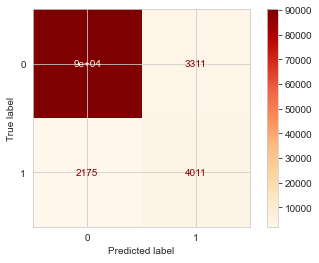

In [4]:
        # Gets the test set data
test_data = get_data(mode='test')

# selects the best model
best_model = rf_detector.best_estimator_

def get_performance(model, data):
    
    """plots performance of the model based on dataset provided returns: None"""
    y_pred = model.predict(data[config.FEATURES])
    y_test = data[config.TARGET]
    results = {
		'Accuracy': [],
		'F1_Score': [],
		'Recall_Score': []
	}

    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1_Score'].append(f1_score(y_test, y_pred))
    results['Recall_Score'].append(recall_score(y_test, y_pred))
    print(pd.DataFrame(results))
    plot_confusion_matrix(model, data[config.FEATURES], data[config.TARGET], cmap="OrRd")
    plt.show()

get_performance(best_model, test_data)


In [6]:
feature_importance = get_feature_importance(best_model,10)
feature_importance

,weight,variable
4,0.216999,education
9,0.171257,major occupation code
32,0.075815,weeks worked in year
0,0.072381,age
3,0.062296,detailed occupation recode
18,0.050518,dividends from stocks
8,0.045205,major industry code
21,0.040598,detailed household and family stat
19,0.039012,tax filer stat
23,0.033648,num persons worked for employer
